# Configure colab and pull repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd /content/drive/My Drive/Picasso

/content/drive/My Drive/Picasso


In [11]:
# !git clone https://github.com/anubhabPanda/Picasso.git
!git pull

Already up to date.


In [12]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 6.7MB/s 
     |████████████████████████████████| 952kB 22.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=3b44fd5112d0de125b69bf2d83c0921b4ee3165c8781944824c35b9139a41030
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Imports

In [13]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import os
from utilities import utils, config, cuda, save_load
from dataset import dataset
from main_engine import engine, schedulers
from models import model11
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from gradcam import GradCAMView
from main_engine.lr_finder import LRFinder
import cv2

In [14]:
#Initialize cuda
cuda, device = cuda.initialize_cuda(config.SEED)

GPU Available? True


In [15]:
config.EPOCHS = 24
config.BATCH_SIZE = 512

# Visualize Dataset

In [16]:
trainset = dataset.torch_datasets(True, True, dataset_name='cifar10')
testset = dataset.torch_datasets(False, True, dataset_name='cifar10')

Extracting /content/drive/My Drive/Picasso/dataset/../cifar10/cifar-10-python.tar.gz to /content/drive/My Drive/Picasso/dataset/../cifar10
Files already downloaded and verified


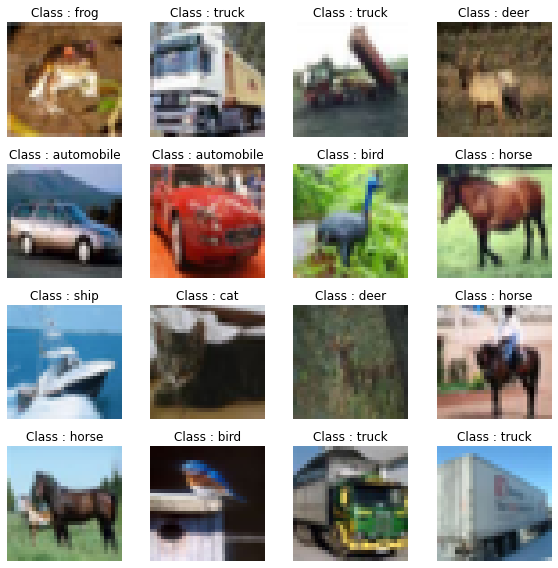

In [17]:
utils.show_imgs(trainset, 16, (8, 8))

# Create DataLoader and Transformations

In [18]:
mean, std = utils.get_stats(trainset)[0], utils.get_stats(trainset)[1]
print(mean, std)

(0.4914, 0.4822, 0.4465) (0.247, 0.2435, 0.2616)


In [19]:
transformations_list = [A.Normalize(mean, std)]
augmentations_list = [
                      A.PadIfNeeded(min_height=40, min_width=40, border_mode = cv2.BORDER_REFLECT, always_apply=True),
                      A.RandomCrop(height=32, width=32, always_apply=True),
                      A.HorizontalFlip(p=0.6),
                      A.Cutout(2, 8, 8, fill_value=mean, p=0.5)
                     ]

In [20]:
trainset = dataset.torch_datasets(True, True, transformations_list, augmentations_list, dataset_name='cifar10')
testset = dataset.torch_datasets(False, True, transformations_list, dataset_name='cifar10')
train_dl = dataset.data_loader(trainset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset.data_loader(testset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


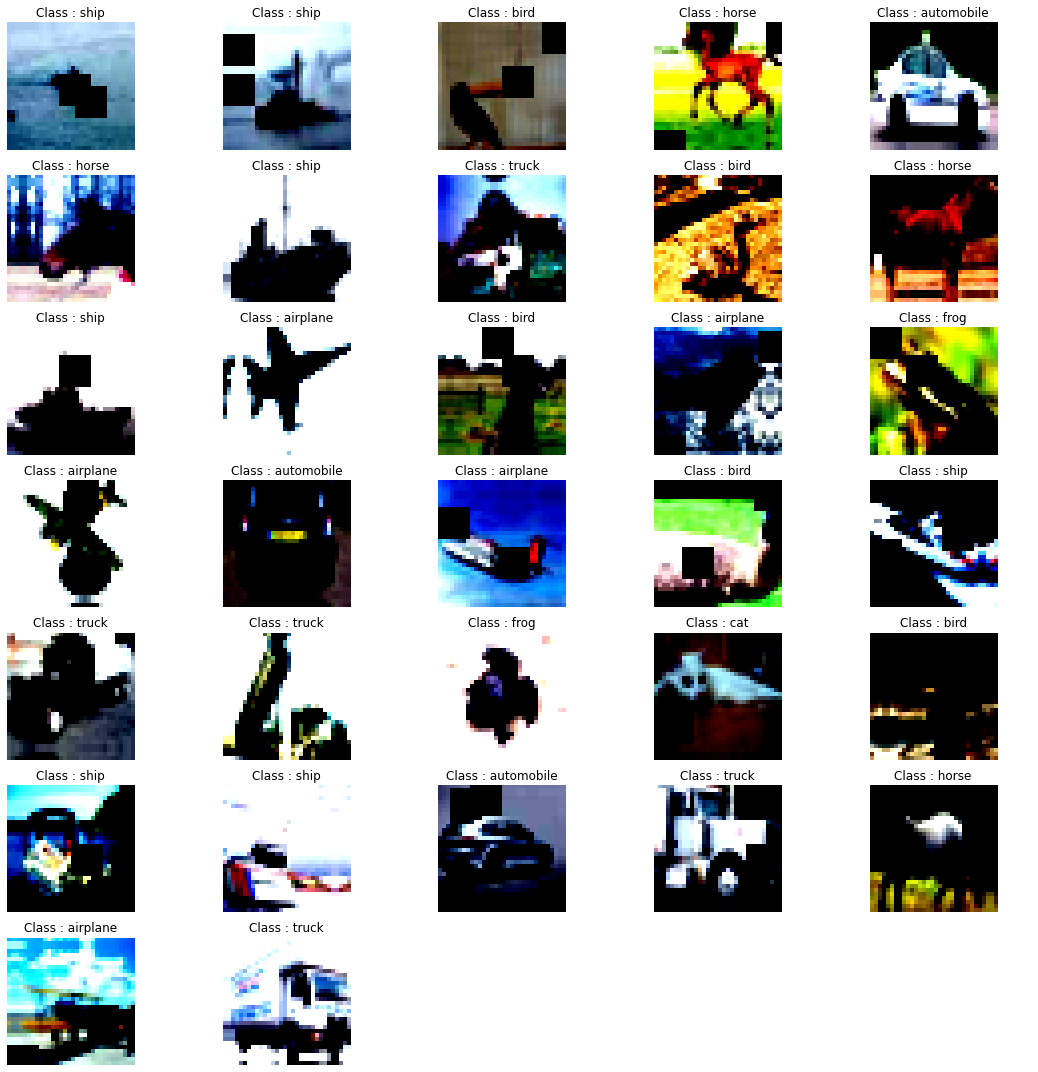

In [21]:
utils.show_batch(train_dl)

# Model Architecture

In [22]:
#Define model
model = model11.call_model().to(device)
utils.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
   Residual_Block-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

# LR Range Test

In [23]:
model = model11.call_model().to(device)
loss_fn = utils.nll_loss()
optimizer = utils.sgd_optimizer(model, lr=0.01)
lr_finder = LRFinder(model, optimizer, loss_fn, device)
lr_finder.range_test(train_dl, start_lr=0.001, end_lr=1, num_iter=len(train_dl)*config.EPOCHS, step_mode='linear')

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 8.65E-03


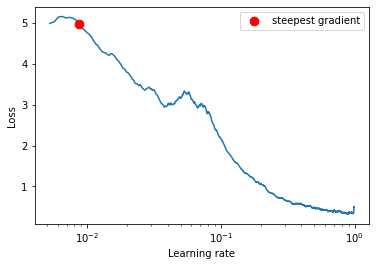

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6f314819e8>,
 0.008648660144619312)

In [24]:
lr_finder.plot()

In [30]:
max_lr = 0.02
model = model11.call_model().to(device)
loss_fn = utils.nll_loss()
optimizer = utils.sgd_optimizer(model, lr=0.01, momentum=0.9)
if config.DEBUG == True:
    config.EPOCHS = 2

scheduler = schedulers.OneCylePolicy(optimizer, max_lr=max_lr,
                                     epochs = config.EPOCHS, steps_per_epoch=1, pct_start=5/config.EPOCHS, 
                                     anneal_strategy='linear', div_factor=10.0, final_div_factor=1.0)
test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{config.EPOCHS}\n")
    engine.train(model, train_dl, optimizer, loss_fn, device, train_losses, train_accuracy)
    engine.test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
    scheduler.step()

  0%|          | 0/98 [00:00<?, ?it/s]

Running Epoch 1/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0026, Accuracy: 5361/10000 (53.61%)

Running Epoch 2/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0025, Accuracy: 5730/10000 (57.30%)

Running Epoch 3/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0018, Accuracy: 6956/10000 (69.56%)

Running Epoch 4/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0018, Accuracy: 7079/10000 (70.79%)

Running Epoch 5/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0017, Accuracy: 7344/10000 (73.44%)

Running Epoch 6/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0015, Accuracy: 7658/10000 (76.58%)

Running Epoch 7/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0013, Accuracy: 7905/10000 (79.05%)

Running Epoch 8/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0012, Accuracy: 8048/10000 (80.48%)

Running Epoch 9/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 8236/10000 (82.36%)

Running Epoch 10/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0013, Accuracy: 8039/10000 (80.39%)

Running Epoch 11/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8495/10000 (84.95%)

Running Epoch 12/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0012, Accuracy: 8261/10000 (82.61%)

Running Epoch 13/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8533/10000 (85.33%)

Running Epoch 14/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8516/10000 (85.16%)

Running Epoch 15/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8676/10000 (86.76%)

Running Epoch 16/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8676/10000 (86.76%)

Running Epoch 17/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8626/10000 (86.26%)

Running Epoch 18/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8739/10000 (87.39%)

Running Epoch 19/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8784/10000 (87.84%)

Running Epoch 20/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8907/10000 (89.07%)

Running Epoch 21/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8766/10000 (87.66%)

Running Epoch 22/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8903/10000 (89.03%)

Running Epoch 23/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8957/10000 (89.57%)

Running Epoch 24/24



Loss=0.19 Batch_ID=97 Accuracy=94.59: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]



Validation set: Average loss: 0.0007, Accuracy: 9003/10000 (90.03%)



In [31]:
# Saving Model
save_load.save_model(model, "EVA5S11.pth")

Model saving successful


In [33]:
#Load Model and set to eval


#Load the saved model
model = save_load.load_model(model, "EVA5S11.pth")

In [34]:
one_batch = next(iter(test_dl))[0]
batch_imgs = []

for i in range(len(one_batch)):
    if i < 25:
        batch_imgs.append(one_batch[i])

# Misclassified Images

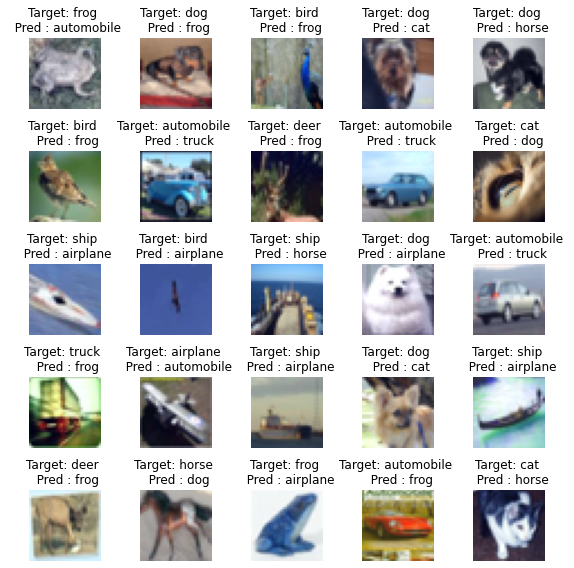

In [42]:
class_idx = trainset.class_to_idx
utils.plot_incorrect_images(misclassified_imgs, class_idx, plot_size=(8, 8))

# Validation Plots

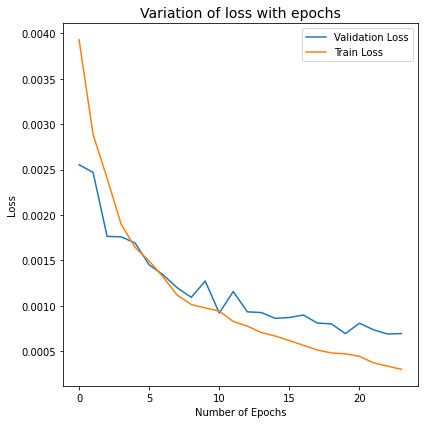

In [43]:
utils.plot_metrics([{'metric':test_loss, 'label':'Validation Loss'},
                    {'metric':train_losses, 'label':'Train Loss'}], "Loss")

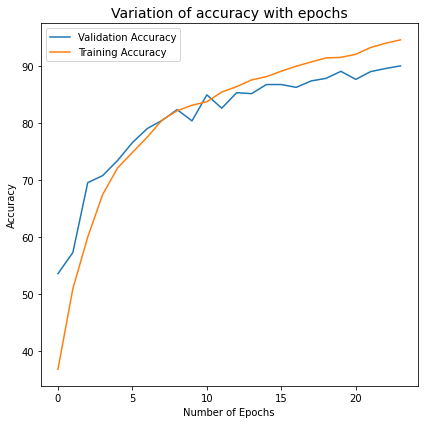

In [44]:
utils.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")